# Introduction to cellstate

`cellstate` is a python package for analysis of UMI-based single-cell RNA-seq data. The underlying mathematical model infers clusters of cells that are in the same gene expression state, meaning that all remaining heterogeneity within each cluster can be explained by expected measurement noise. Thus, we find the most fine-grained clustering that is  supported by the data. Furthermore, we describe the higher-order relationship of these cell-states in a hierarchical tree and provide scores for marker-genes within this tree.

# Installation

Installation of the cellstate python package can simply be done by going in the package folder and running 

`python setup.py install`

# Commandline tool



The most **basic version**, can be run through the command line as follows:

`python run_cellstate.py --data data.tsv`

The **input** is a table of integer UMI counts. The commandline tool currently supports the following formats:
* A tab-separated values file with .tsv or .txt ending. Columns are cells, rows are genes. 
* A numpy array of integers saved as .npy file


It returns the following **results**:
* `optimized_clusters.txt`: indicates for each cell in which cell-state they are (cellstates are assigned an arbitrary number)
* `cluster_hierarchy.tsv`: The relationship between cell-states can be described through a hierarchical tree. Leaves in this tree are cell-states which are iteratively merged into higher-order clusters. This tree structure is saved as a tab separated value file with three columns:
    * cluster_new: Cluster/cell-state to be merged and label of new merged cluster
    * cluster_old: Other cluster/cell-state to be merged with cluster_new
    * Delta_LL: Change in log-likelihood (usually negative; the more negative, the more different are the merged clusters)
* `hierarchy_gene_scores.tsv`: For each merging-step in the hierarchical tree, we can give a score for how much a gene contributes to the separation of the two branches (large negative score). In this tab-separated value file, the first three columns are the same as in `cluster_hierarchy.tsv`, indicating the merging step, and the following columns are the scores for each gene. 
* `dirichlet_pseudocounts.tsv`: The prior parameters for which the optimum was found. 

Further possible inputs can be seen by calling the help for `run_cellstate.py` 

In [61]:
! python run_cellstate.py --help

usage: run_cellstate.py [-h] [-o OUTDIR] [--data DATA] [-d DIRICHLET]
                        [-i INIT] [-t THREADS]

optional arguments:
  -h, --help            show this help message and exit
  -o OUTDIR, --outdir OUTDIR
                        directory for output
  --data DATA           UMI data (path to file)
  -d DIRICHLET, --dirichlet DIRICHLET
                        dirichlet prior parameter
  -i INIT, --init INIT  init clusters (path to file)
  -t THREADS, --threads THREADS
                        number of threads


Additional comments for selected parameters:
* `DIRICHLET`: If given, the model is run only with the given parameter, otherwise the parameter will be optimized
* `INIT`: Cluster labels should be given in a simple text file separated by line breaks or as a binary .npy file. 
* `THREADS`: Default is to use all available cores minus one

# Python module

Some more advanced functionalities of cellstates can currently only be accessed by running cellstates through python or by loading the output files of the commandline tool into python. 

In [1]:
import cellstates as cs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [161]:
# load data

datafile = './test_data/simulated_data.tsv.zip'
df = pd.read_csv(datafile, sep='\t', index_col=0)

data = df.values.astype(np.int)
all_genes = df.index.values
cells = df.columns.values

G, N = data.shape
G, N

(19052, 2298)

The information about a dataset is stored in a `cs.Cluster` object. 

In [3]:
help(cs.Cluster)

Help on class Cluster in module cellstates.cluster:

class Cluster(builtins.object)
 |  Object that contains SC expression data, lambda and stores a partition
 |  
 |  Parameters
 |  ----------
 |  d : 2D array of ints
 |      UMI count array of shape (N_genes, N_cells)
 |  l : 1D array or float, default=None
 |      If array, the pseudo-counts lambda for each gene. Has to be of shape (N_genes, ).
 |      All entries must be > 0. If float, defines the magnitude of the pseudo-counts,
 |      but their relative sizes is set by data average. If None, magnitude is chosen
 |      automatically.
 |  c : 1D array of ints, default=None
 |      Cluster labels for each cell. Has to be of shape (N_cells, ).
 |      Labels must be positive and < N_boxes. If None, every cell is in its own cluster.
 |  genes : 1D array, optional
 |      Names of genes; does not have to be set.
 |  max_clusters : int, default 0
 |      Maximum number of clusters allowed (acces through item N_boxes).
 |      if max_cl

In [4]:
# creating a new object with default settings
clst = cs.Cluster(data)

The object stores a partition of the cells into cellstates (accessed through `clst.clusters`). By default, each cell is in its own cellstate.

In [5]:
clst.clusters

array([   0,    1,    2, ..., 2295, 2296, 2297])

## Optimization of partition
**NOTE:** The full optimization of both the partition and the prior is currently only implemented in the commandline tool. Only optimize the partition through python if you understand the mathematical model. 

The aim is to find the partition that maximises the log-likelihood of our model. 
The mathematical model has three inputs: The data, the partition and a set of prior parameters (automatically chosen by default and accessed through `clst.dirichlet_pseudocounts`) and returns a likelihood.
Thus, changing the partition changes the likelihood.

In [6]:
clst = cs.Cluster(data)
print(clst.total_likelihood)

-83483186.21598381


In [9]:
clst.move_cell(0, 1) # move cell 0 into cluster 1
print(clst.clusters)
print(clst.total_likelihood) # likelihood changed

[   1    1    2 ... 2295 2296 2297]
-83483068.42137295


To efficiently optimize the likelihood, we need to initialize the `cs.Cluster` object with multiple threads and a large cache.  

In [12]:
clst = cs.Cluster(data, num_threads=8, n_cache=1000)

An Markov-chain Monte Carlo algorithm is used to optimize likelihood as a function of the partition. This will change the partition and the likelihood.

In [13]:
clst.biased_monte_carlo_sampling(N_steps=500, tries_per_step=100)

In [15]:
print(clst.clusters[:10])
clst.total_likelihood

[11  1  2 38  4  5  7  7  8  9]


-83414230.75218931

For the full optimization run, the sampling is repeatedly called. At the end, there are also deterministic optimization steps (merging clusters, moving cells into their optimal cluster)

In [16]:
cs.run_mcmc(clst, N_steps=100)

2020-04-08 01:34:10,277 - INFO:initially check output every 100 steps
2020-04-08 01:34:10,279 - INFO:n_clusters=1952, total likelihood=-83414230.75218931
2020-04-08 01:34:13,840 - INFO:n_clusters=1912, total likelihood=-83397932.39926681
2020-04-08 01:34:16,953 - INFO:n_clusters=1860, total likelihood=-83377156.09167968
2020-04-08 01:34:20,559 - INFO:n_clusters=1816, total likelihood=-83358029.69227916
2020-04-08 01:34:24,014 - INFO:n_clusters=1766, total likelihood=-83337410.67785498
2020-04-08 01:34:28,969 - INFO:n_clusters=1720, total likelihood=-83319426.64833075
2020-04-08 01:34:33,436 - INFO:n_clusters=1658, total likelihood=-83294878.93906307
2020-04-08 01:34:37,211 - INFO:n_clusters=1606, total likelihood=-83269463.97425419
2020-04-08 01:34:41,517 - INFO:n_clusters=1553, total likelihood=-83240605.10355274
2020-04-08 01:34:46,009 - INFO:n_clusters=1500, total likelihood=-83214807.97799055
2020-04-08 01:34:50,294 - INFO:n_clusters=1448, total likelihood=-83184136.50102948
2020-0

In [17]:
print(clst.total_likelihood)
print(clst.n_clusters)

-81457510.71362098
9


comparison to true cluster labels shows a slight disagreement

In [18]:
from sklearn.metrics import adjusted_rand_score
sim_clusters = np.loadtxt('./test_data/simulated_clusters.txt', dtype=int)
adjusted_rand_score(sim_clusters, clst.clusters)

0.9811421746094137

However, when we calculate the likelihood of the true clusters, we see that it is actually smaller. This can one of means that under the current prior, the data is insufficient to resolve two of the simulated cellstates. However, with a different prior we might get a higher likelihood and sufficient resolution. 


In [21]:
# Find likelihood of true partition with current 
sim_clst = cs.Cluster(data, c=sim_clusters)
sim_clst.total_likelihood

-81458341.62652262

## Analysing the model outputs

In [40]:
# build cs.Cluster object from model outputs
prior = np.loadtxt('./test_results/dirichlet_pseudocounts.txt')
clusters = np.loadtxt('./test_results/optimized_clusters.txt', dtype=np.int)
gene_filter = np.any(data, axis=1)  # need to filter out non-expressed genes
genes = all_genes[gene_filter]
clst = cs.Cluster(data[gene_filter, :], prior, clusters)

Basic statistics like cluster sizes can easily be checked

In [39]:
print(clst.n_clusters)  # number of cellstates
clst.cluster_sizes[:10]

10


array([ 41, 138, 118,  28, 200, 836, 109, 255, 457, 116])

In [81]:
# perform PCA for visualization
from sklearn.decomposition import PCA

tpm_data = 1E6*data/data.sum(axis=0)
X = np.log2(tpm_data + 1).T
pca = PCA(n_components=16)
pca.fit(X)
X_pca = pca.transform(X)

pca.explained_variance_ratio_

array([0.0471236 , 0.03330016, 0.00966126, 0.0087808 , 0.00627348,
       0.00327353, 0.00297444, 0.00198459, 0.00142925, 0.00120155,
       0.00108139, 0.00087488, 0.00085363, 0.00084833, 0.0008472 ,
       0.00084176])

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa17c928b70>,
       dtype=object))

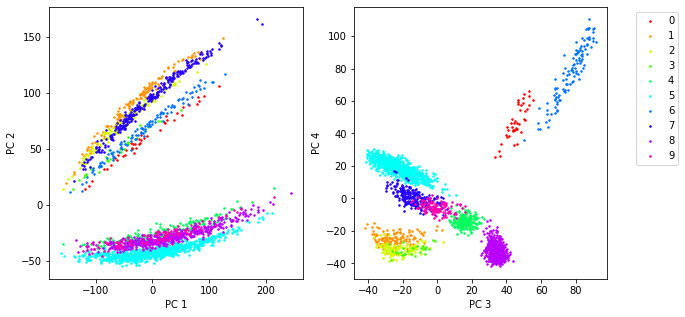

In [82]:
from cycler import cycler
import matplotlib
def plot_pca(clusters, pc=None):
    cluster_names = np.unique(clusters)
    n_c = len(cluster_names)
    colors = plt.cm.hsv(np.linspace(0, 1, n_c+1))
    matplotlib.rcParams['axes.prop_cycle'] = cycler(color=colors)
    
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    
    for i, ax in enumerate(axs.flatten()):

        if pc is None:
            j1 = 2*i+0
            j2 = 2*i+1
        else:
            j1 = pc[2*i] - 1
            j2 = pc[2*i+1] - 1
        
        x = X_pca[:, j1]
        y = X_pca[:, j2]
        for c in cluster_names:
            cond = clusters==c
            ax.plot(x[cond], y[cond], '.', ms=3, label=c)


        ax.set_xlabel('PC {}'.format(j1+1))

        ax.set_ylabel('PC {}'.format(j2+1))
    l = plt.legend(ncol=1)
    l.set_bbox_to_anchor([1.3, 1])
    
    return fig, axs
plot_pca(clst.clusters)

### Hierarchical merging of clusters
* in every step we are looking for the two clusters that when merged result in the smallest change in LL

In [26]:
# The code below shows how to get the cluster hierarchy from a Cluster object
# this is not necessary if you ran the command line tool
cluster_hierarchy, delta_LL_history = clst.get_cluster_hierarchy()

print(cluster_hierarchy)
print(delta_LL_history)
hierarchy_df = cs.get_hierarchy_df(cluster_hierarchy, delta_LL_history)
hierarchy_df

[(1, 2), (1, 3), (0, 6), (4, 9), (4, 8), (0, 7), (0, 1), (4, 5), (0, 4)]
[-3115.865835720673, -31243.48483569175, -35013.31615561992, -73835.62327904627, -122084.78261580318, -130306.56701968424, -263133.4075333476, -419831.88582114875, -1076261.123359993]


,cluster_new,cluster_old,delta_LL
0,1,2,-3.115866e+03
1,1,3,-3.124348e+04
2,0,6,-3.501332e+04
3,4,9,-7.383562e+04
4,4,8,-1.220848e+05
5,0,7,-1.303066e+05
6,0,1,-2.631334e+05
7,4,5,-4.198319e+05
8,0,4,-1.076261e+06


In [57]:
# to load the same results from the command line tool output run
hierarchy_df = pd.read_csv('./test_results/cluster_hierarchy.tsv', sep='\t')
hierarchy_df

,cluster_new,cluster_old,delta_LL
0,1,2,-2.799456e+03
1,1,3,-2.517581e+04
2,0,6,-3.356393e+04
3,4,9,-7.918575e+04
4,4,8,-1.304314e+05
5,0,7,-1.309473e+05
6,0,1,-2.654589e+05
7,4,5,-4.291468e+05
8,0,4,-1.083290e+06


The module contains functions that can transform these trees into **other formats**:
* scipy linkage matrix: 
    * integrated into python
    * only allows one leaf per cluster
    * only positive distances allowed
    
* Newick format
    * widely used for phylogenetic trees with plotting libraries available
    * allows for one leaf per cell
    * only positive distances allowed in plotting tool I use

In [31]:
# scipy linkage matrix
Z = cs.get_scipy_hierarchy(hierarchy_df)
Z

array([[1.00000000e+00, 2.00000000e+00, 2.79945610e+03, 2.00000000e+00],
       [3.00000000e+00, 1.00000000e+01, 2.51758050e+04, 3.00000000e+00],
       [0.00000000e+00, 6.00000000e+00, 3.35639309e+04, 2.00000000e+00],
       [4.00000000e+00, 9.00000000e+00, 7.91857547e+04, 2.00000000e+00],
       [8.00000000e+00, 1.30000000e+01, 1.30431418e+05, 3.00000000e+00],
       [7.00000000e+00, 1.20000000e+01, 1.30947264e+05, 3.00000000e+00],
       [1.10000000e+01, 1.50000000e+01, 2.65458853e+05, 6.00000000e+00],
       [5.00000000e+00, 1.40000000e+01, 4.29146760e+05, 4.00000000e+00],
       [1.60000000e+01, 1.70000000e+01, 1.08329042e+06, 1.00000000e+01]])

(<Figure size 648x432 with 1 Axes>,
 {'icoord': [[15.0, 15.0, 25.0, 25.0],
   [5.0, 5.0, 20.0, 20.0],
   [45.0, 45.0, 55.0, 55.0],
   [35.0, 35.0, 50.0, 50.0],
   [12.5, 12.5, 42.5, 42.5],
   [85.0, 85.0, 95.0, 95.0],
   [75.0, 75.0, 90.0, 90.0],
   [65.0, 65.0, 82.5, 82.5],
   [27.5, 27.5, 73.75, 73.75]],
  'dcoord': [[0.0, 2799.4561047255993, 2799.4561047255993, 0.0],
   [0.0, 25175.805036682643, 25175.805036682643, 2799.4561047255993],
   [0.0, 33563.93088111002, 33563.93088111002, 0.0],
   [0.0, 130947.26361362074, 130947.26361362074, 33563.93088111002],
   [25175.805036682643,
    265458.8526603468,
    265458.8526603468,
    130947.26361362074],
   [0.0, 79185.75470019133, 79185.75470019133, 0.0],
   [0.0, 130431.41800412536, 130431.41800412536, 79185.75470019133],
   [0.0, 429146.76006835705, 429146.76006835705, 130431.41800412536],
   [265458.8526603468,
    1083290.4226038605,
    1083290.4226038605,
    429146.76006835705]],
  'ivl': ['3', '1', '2', '7', '0', '6', '5', '8', '

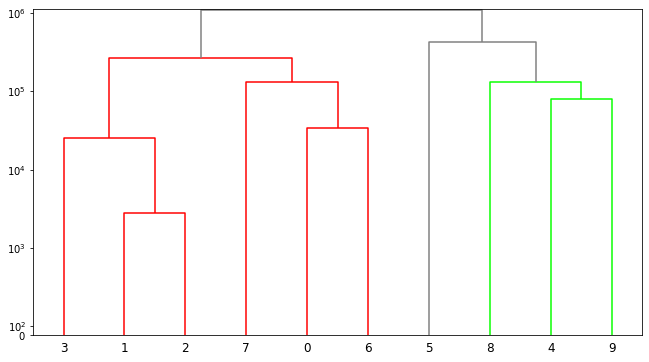

In [32]:
# simple plotting built into cellstate library
cs.plot_hierarchy_scipy(hierarchy_df, n_groups=3)

Create a newick string from the hierarchy and use it to generate a Tree in ete3. Check their documentation 

In [33]:
# I need to properly set the DISPLAY environment to run ete3 on a remote server
# You should probably not run this
import os
os.environ['DISPLAY'] = 'localhost:10.0'  # match to 
!echo $DISPLAY

localhost:10.0


In [58]:
from ete3 import Tree
newick_string = cs.hierarchy_to_newick(hierarchy_df, clst.clusters, cell_leaves=False)
t = Tree(newick_string, format=1)

node = t.search_nodes(name="I2")[0]
print(node)


         /-C0
      /-|
   /-|   \-C6
  |  |
  |   \-C7
--|
  |      /-C1
  |   /-|
   \-|   \-C2
     |
      \-C3


In the newick format, internal nodes are labelled I0 (root), I1, etc. from the root towards the leaves, following the hierarchy. Cellstate nodes are called C0, C1, ... corresponding to cellstates 0, 1, ... - cells can be included as leaves branching off each cellstate node

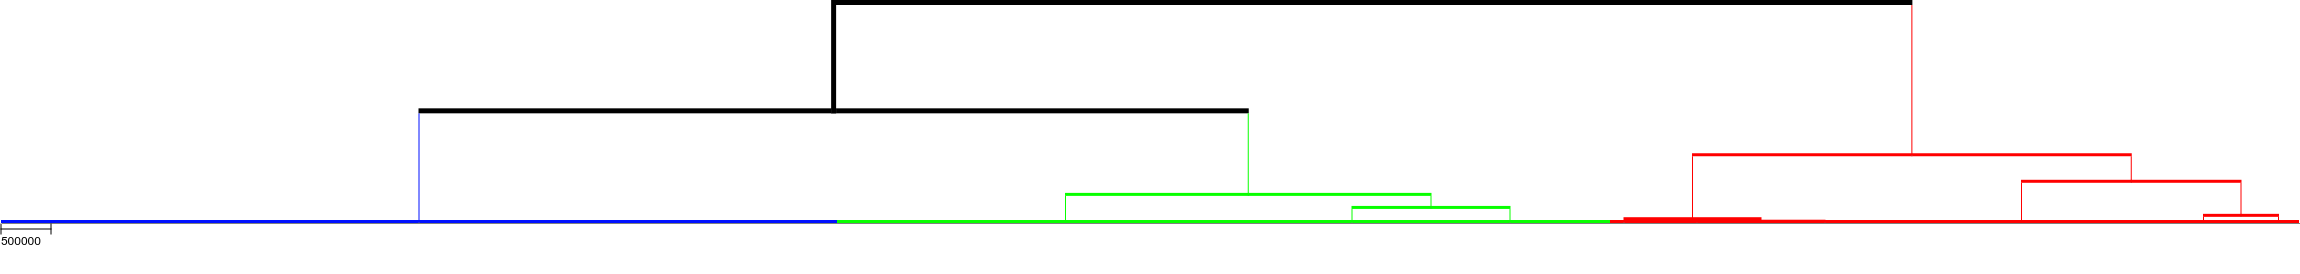

In [34]:
# this built-in function automatically generates a tree visualization with ete3
t, ts = cs.plot_hierarchy_ete3(hierarchy_df, clst.clusters, n_groups=3)
t.render('%%inline', tree_style=ts)

### Finding marker genes

In [41]:
# load gene names
genes = np.load('./test_data/genes.npy', allow_pickle=True)
genes = genes[gene_filter]

In [62]:
# Scores can be calculated in python from a new Cluster object
score_table = cs.marker_score_table(clst, hierarchy_df)

score_df = pd.concat([hierarchy_df, pd.DataFrame(score_table, columns=genes)], axis=1)
score_df


,cluster_new,cluster_old,delta_LL,A1BG_AS1__chr19,A1BG__chr19,A1CF__chr10,A2M_AS1__chr12,A2ML1__chr12,A2M__chr12,A4GALT__chr22,...,ZWILCH__chr15,ZWINT__chr10,ZXDA__chrX,ZXDB__chrX,ZXDC__chr3,ZYG11A__chr1,ZYG11B__chr1,ZYX__chr7,ZZEF1__chr17,ZZZ3__chr1
0,1,2,-2.799456e+03,0.008366,-1.102232,-4.232164,0.036251,-0.605492,0.276067,-2.452648,...,-3.019516,-0.964655,1.366641,-0.626765,1.594102,-0.716861,1.566805,-2.391568,0.610499,1.756219
1,1,3,-2.517581e+04,0.006470,-0.330565,0.142516,0.028037,-0.207337,0.213511,3.089768,...,2.092508,-2.537675,0.012644,-0.939584,-1.454842,0.023723,0.956615,-5.967538,1.208989,1.002209
2,0,6,-3.356393e+04,-0.610493,-0.493802,-1.327825,2.436164,-1.264768,-2.823463,3.459633,...,1.183685,2.510630,0.555562,-2.730519,1.316217,-1.258036,0.527953,2.398659,1.610231,0.986841
3,4,9,-7.918575e+04,-0.453485,1.633728,1.811375,3.357344,-1.934031,-0.686837,0.061934,...,1.334888,2.110837,-1.409430,2.185098,-5.472517,-0.946370,-2.749523,0.573528,2.036285,0.459126
4,4,8,-1.304314e+05,-1.173249,2.086876,-3.554949,3.715520,-0.334183,0.340036,-0.289532,...,0.882052,1.848019,1.155879,2.557124,-2.877914,-1.047200,-0.792281,1.834111,2.449018,2.526647
5,0,7,-1.309473e+05,0.007100,0.130162,-1.303005,1.338300,-1.891385,-77.638124,3.275564,...,1.802864,1.897307,1.946103,-5.720293,1.021047,3.257286,0.950882,2.441552,0.421395,1.214529
6,0,1,-2.654589e+05,0.006825,-0.413413,1.326825,-2.771168,3.423143,-61.394725,3.259957,...,1.396531,2.515930,0.363012,-4.712056,1.312069,-1.375344,-1.962104,2.049942,0.151447,0.932372
7,4,5,-4.291468e+05,-1.616135,1.621051,-14.045811,0.633909,-0.621690,0.351326,0.074524,...,2.591703,2.397851,0.168671,1.685523,1.503854,-0.611043,2.287914,1.805347,-0.896838,-1.032231
8,0,4,-1.083290e+06,-0.175209,-0.417827,-6.662264,3.049471,-1.730135,-76.722873,-3.448556,...,1.832141,0.596680,1.440872,-4.955827,-1.041175,-1.723104,-1.557746,-16.711297,1.561580,1.197210


In [70]:
# Alternatively, load results from a previous run
score_df = pd.read_csv('./test_results/hierarchy_gene_scores.tsv', sep='\t')
gene_scores = score_df.iloc[:, 3:]

The scores allow you to check which genes were important in each step of the hierarchy. 
The following analysis shows the important genes for the second to last merge (clusters 4 and 5 get merged). 

In [132]:
n_groups = 3  # number of clusters left at the point we consider in the hierarchy
n_merges = hierarchy_df.shape[0]
n_steps = n_merges - n_groups + 1

n_top = 20  # number of top genes considered
gene_importance_order = np.argsort(gene_scores.loc[n_steps])
top_genes = genes[gene_importance_order[:n_top]]
top_genes

array(['SST__chr3', 'GCG__chr2', 'TTR__chr18', 'RBP4__chr10',
       'PCSK1__chr5', 'ALDH1A1__chr9', 'MALAT1__chr11', 'TM4SF4__chr3',
       'GC__chr4', 'CHGB__chr20', 'SEC11C__chr18', 'PRG4__chr1',
       'AQP3__chr9', 'SCG2__chr2', 'VGF__chr7', 'PCSK2__chr20',
       'HADH__chr4', 'RGS2__chr1', 'LEPR__chr1', 'LOXL4__chr10'],
      dtype=object)

We can also find the clusters at this point in the hierarchy:

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa116506c88>,
       dtype=object))

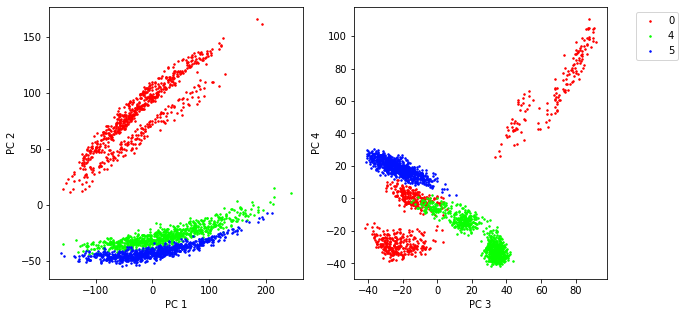

In [133]:
merged_clusters = cs.clusters_from_hierarchy(hierarchy_df, clst.clusters.copy(), n_steps)
merged_clst = cs.Cluster(data[gene_filter, :], clst.dirichlet_pseudocounts, merged_clusters)
plot_pca(merged_clusters)

Next, we find the inferred gene expression states of these higher-order clusters. We can choose either to get modal values (`get_expressionstate`) or mean and variance (`get_expressionstate_mv`)

In [134]:
cluster_labels, = np.nonzero(merged_clst.cluster_sizes)
expressionstates = pd.DataFrame(np.vstack([merged_clst.get_expressionstate(c) for c in cluster_labels]),
                                columns=genes, index=cluster_labels)
expressionstates[top_genes]

,SST__chr3,GCG__chr2,TTR__chr18,RBP4__chr10,PCSK1__chr5,ALDH1A1__chr9,MALAT1__chr11,TM4SF4__chr3,GC__chr4,CHGB__chr20,SEC11C__chr18,PRG4__chr1,AQP3__chr9,SCG2__chr2,VGF__chr7,PCSK2__chr20,HADH__chr4,RGS2__chr1,LEPR__chr1,LOXL4__chr10
0,0.003088,0.003125,0.001498,0.000044,0.000025,0.000400,0.014880,0.000157,0.000105,0.000143,0.000231,0.000016,0.000070,0.000131,0.000074,0.000114,0.000068,0.000092,0.000014,0.000024
4,0.028766,0.004346,0.006558,0.003981,0.001456,0.000891,0.026086,0.000346,0.000164,0.002073,0.001527,0.000354,0.000518,0.001994,0.001007,0.001092,0.000757,0.000253,0.000133,0.000024
5,0.005040,0.075560,0.046550,0.000132,0.000114,0.003945,0.035738,0.002670,0.001921,0.007176,0.000599,0.000022,0.000057,0.004053,0.002934,0.003819,0.000035,0.000031,0.000008,0.000769


If we plot these in a heatmap, it is easy to see that these genes separate clusters 4 and 5

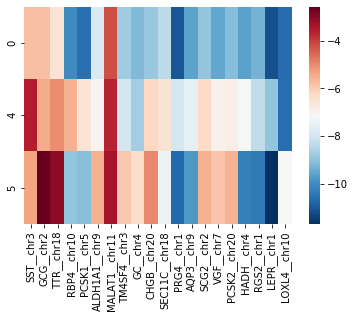

In [135]:
import seaborn as sns
sns.heatmap(np.log(expressionstates[top_genes]), cmap='RdBu_r')

Conversely, genes that have large positive scores will be very similar between these clusters

we can also look at the raw counts for these

In [140]:
gene_scores[bottom_genes]

,ANXA4__chr2,COL1A1__chr17,ALB__chr4,CEL__chr9,CTRB1__chr16,CPA2__chr7,SPARC__chr5,CELA3A__chr1,PLA2G1B__chr12,CPA1__chr7,INS__chr11,PNLIP__chr10,IAPP__chr12,OLFM4__chr13,CTRB2__chr16,PRSS1__chr7,REG3A__chr2,REG1B__chr2,PPY__chr17,REG1A__chr2
0,2.033968,-10.703619,-592.544374,-166.863872,-164.042808,-213.464548,-7.434070,-189.008917,-279.898470,-217.702222,32.092957,-620.061865,24.976374,26.793446,-382.339594,-587.673727,-1883.291310,-968.770190,65.877161,-163.595072
1,-74.386322,11.038291,-16.758926,-3374.169274,-1591.957300,-687.891701,4.980301,-2302.034104,-1111.750719,-2619.012341,28.923776,-2553.127864,23.914890,-73.963617,-2016.876262,-2765.584684,-2.460608,-891.230336,47.140522,-232.862918
2,1.739828,-2528.693299,4.835941,3.846510,5.021033,3.056822,-263.046275,5.728619,2.329755,8.720305,26.498244,10.110102,23.124166,9.586710,15.665241,13.111083,-2.370517,-1.121320,-211.876723,8.677056
3,2.287774,2.657510,5.430648,-18.418752,-68.389515,-0.513271,6.582555,-3.004534,-33.856519,-66.510415,0.273096,-30.887267,-90.412088,12.883416,-31.276698,-35.937247,22.973937,-84.600639,-34239.681576,-161.819038
4,-5.855237,5.441686,5.701485,7.611552,6.246902,5.528053,4.588775,7.306006,8.841480,9.626013,-4856.939301,13.646516,-4643.743883,15.126853,20.013802,19.578398,23.510648,38.776124,27.737777,56.016068
5,-433.918336,8.821468,4.606710,4.865783,5.423044,3.131676,-743.962841,5.821316,4.485339,9.108449,26.936781,10.581550,23.186167,-164.987940,17.212350,13.470860,3.228799,0.932688,-278.983615,27.605642
6,-113.559555,11.088987,-135.449653,-75.748764,-119.062088,-142.836065,-614.077938,-97.141756,-228.605355,-305.310313,26.926846,-322.060283,23.161142,-976.024666,-893.282170,-490.804207,-1420.969694,-1690.509324,-186.496789,-3913.944673
7,5.374097,5.581568,5.987500,6.252352,6.407347,6.907503,6.959784,6.982354,8.752667,10.849471,11.881194,13.314381,13.421749,15.201683,18.988343,19.657412,23.386956,39.574937,49.824016,54.377829
8,3.116249,8.639791,5.343708,4.255911,5.336033,1.125820,-740.604656,5.812638,3.059039,9.403414,10.727340,10.451596,11.350849,9.511945,17.245815,12.679907,-3.165570,-20.683259,-125.032266,5.001619


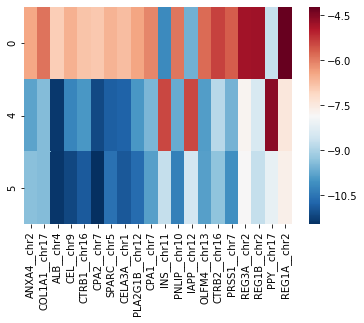

In [136]:
bottom_genes = genes[gene_importance_order[-n_top:]]

sns.heatmap(np.log(expressionstates[bottom_genes]), cmap='RdBu_r')

In [142]:
merged_clst.cluster_umi_counts[gene_importance_order[-n_top:]][:, cluster_labels]

array([[ 4851,   198,   319],
       [ 8685,   286,   300],
       [ 2897,    41,    42],
       [ 4341,   125,    52],
       [ 3417,   167,    69],
       [ 3214,    52,    38],
       [ 4216,    67,    96],
       [ 3722,    72,    67],
       [ 5076,   168,    87],
       [ 7035,   259,   198],
       [  109, 15894,   612],
       [ 8354,   216,   119],
       [  201, 15849,   742],
       [ 9298,   179,   195],
       [14192,   507,   337],
       [10703,   241,   151],
       [25390,  1513,  1479],
       [25743,   765,   602],
       [  490, 36722,  1080],
       [45056,  2076,  1804]])